In [1]:
## Roberta Analysis
# Anita Sun

In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import torch
import tensorflow.keras as tf_keras
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

### Roberta Prep

In [3]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# # TF
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

text = "Celebrating my promotion 😎"
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)
scores = output[0][0].numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

2025-02-27 17:48:09.187939: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


1) joy 0.9382
2) optimism 0.0362
3) anger 0.0145
4) sadness 0.0112


In [43]:
def sentimizer(text):
    tokenized = tokenizer(text, return_tensors='tf', truncation=True, max_length=512)
    output = model(tokenized)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    #print(scores, labels)
    #df.loc[len(df)] = [id, string, np.nan, np.nan, np.nan, np.nan]

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    print(text)

    return list(scores)

In [11]:
df = pd.read_csv('tweets_01-08-2021.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date']) # converting to datetime

In [85]:
df.columns

Index(['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites',
       'retweets', 'date', 'isFlagged'],
      dtype='object')

In [ ]:
start_date = '2016-11-05'
end_date = '2021-01-07'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
# selecting for appropriate timeframe

In [ ]:
df = df[~df['text'].str.match(r'^RT\b', na=False)]

# removing retweets

In [ ]:
df = df[~df['text'].str.match(r'^https\b', na=False)]

# removing tweets with only a link

In [16]:
df.shape

(15836, 9)

In [90]:
df['text'][:20]

1     I was thrilled to be back in the Great city of...
3     The Unsolicited Mail In Ballot Scam is a major...
6     Getting a little exercise this morning! https:...
14             Thank you Elise! https://t.co/Y4Hb0zf5jk
15    As per your request, Joe... https://t.co/78mzc...
19    The threshold identification of Ballots is tur...
20    “I’m running as a proud Democrat, for the Sena...
21    HUGE win today for the United States and for p...
23             Thank you Megyn! https://t.co/sC71EEWIOd
24               11 DAYS! #MAGA https://t.co/PuqeF1ctDs
26    Nevada is turning out to be a cesspool of Fake...
28    Wisconsin is looking very good. Needs a little...
29    Nobody is showing up for Obama’s hate laced sp...
33    Pennsylvania prevented us from watching much o...
34      Just landed in Ohio. See you in a little while!
36    Georgia will be a big presidential win, as it ...
38      THANK YOU OHIO! #VOTE \nhttps://t.co/5EJjFZVLHZ
39    How can you certify an election when the n

In [91]:
df['scores'] = df['text'].apply(lambda x: sentimizer(x),

                                )

I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y
The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp; the Democrats know it. Almost all recent elections using this system, even though much smaller &amp;  with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp; Fraud!
Getting a little exercise this morning! https://t.co/fyAAcbhbgk
Thank you Elise! https://t.co/Y4Hb0zf5jk
As per your request, Joe... https://t.co/78mzcfLEsF https://t.co/AalVkSfHFi
The threshold identification of Ballots is turning out to be even bigger than originally anticipated. A very large number of Ballots are impacted. Stay tuned!
“I’m running as a proud Democrat, for the Senate”. Sleepy Joe Biden today. It’s only goin

In [92]:
labels

['anger', 'joy', 'optimism', 'sadness']

In [93]:
df['anger'] = df['scores'].apply(lambda x:
                                x[0])
df['joy'] = df['scores'].apply(lambda x:
                               x[1])
df['optimism'] = df['scores'].apply(lambda x:
                                    x[2])
df['sadness'] = df['scores'].apply(lambda x:
                                   x[3])

In [94]:
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,scores,anger,joy,optimism,sadness
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,"[0.017996026, 0.91887456, 0.0560215, 0.0071078...",0.017996,0.918875,0.056022,0.007108
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,"[0.8863315, 0.005368295, 0.016380254, 0.09191985]",0.886331,0.005368,0.016380,0.091920
6,1223640662689689602,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,f,"[0.027001675, 0.7562563, 0.17825153, 0.03849056]",0.027002,0.756256,0.178252,0.038491
14,1215247978966986752,Thank you Elise! https://t.co/Y4Hb0zf5jk,f,f,Twitter for iPhone,48510,11608,2020-01-09 12:24:31,f,"[0.036250062, 0.8392923, 0.101642035, 0.022815...",0.036250,0.839292,0.101642,0.022816
15,1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",f,f,Twitter for iPhone,253761,79855,2020-10-23 04:09:59,f,"[0.3175247, 0.31368554, 0.22997703, 0.13881272]",0.317525,0.313686,0.229977,0.138813


In [95]:
df.to_csv('roberta_tweets.csv')

### Visualization

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

Text(0.5, 1.0, "Distribution of Primary Emotion in Trump's Tweets")

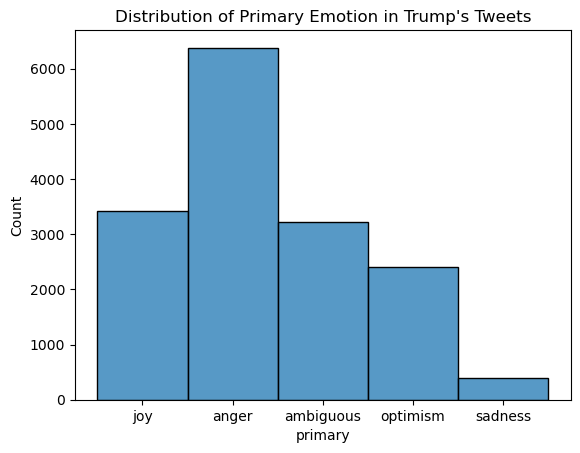

In [157]:
sns.histplot(df,
             x='primary')

plt.title("Distribution of Primary Emotion in Trump's Tweets")

In [237]:
df['isDeleted'].value_counts()

f    15317
t      519
Name: isDeleted, dtype: int64

In [236]:
df['isFlagged'].value_counts()/len(df)

f    0.987055
t    0.012945
Name: isFlagged, dtype: float64

In [ ]:
len(df) # number of tweets

# features not relevant; deep learning w/ textual data

15836

Text(0.5, 1.0, 'Donald Trump RoBERTa Tweet Emotions Over Time')

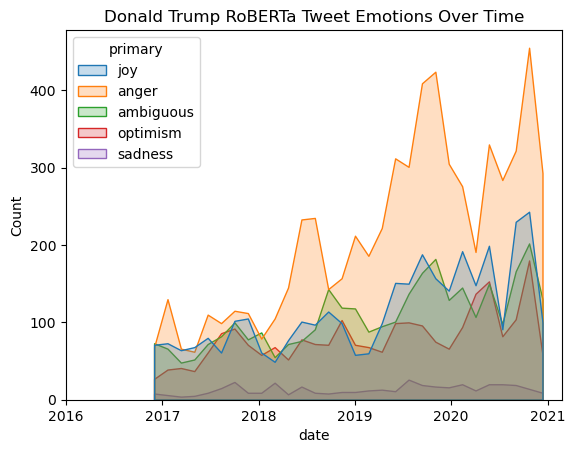

In [163]:
sns.histplot(
    df, x="date", hue="primary", element="poly",
     common_norm=False,
)

plt.xticks(ticks=[date.fromisoformat('2016-01-01'), date.fromisoformat('2017-01-01'),
                   date.fromisoformat('2018-01-01'), date.fromisoformat('2019-01-01'),
                   date.fromisoformat('2020-01-01'), date.fromisoformat('2021-01-01')],
                   labels=['2016','2017','2018','2019','2020','2021'])

plt.title('Donald Trump RoBERTa Tweet Emotions Over Time')

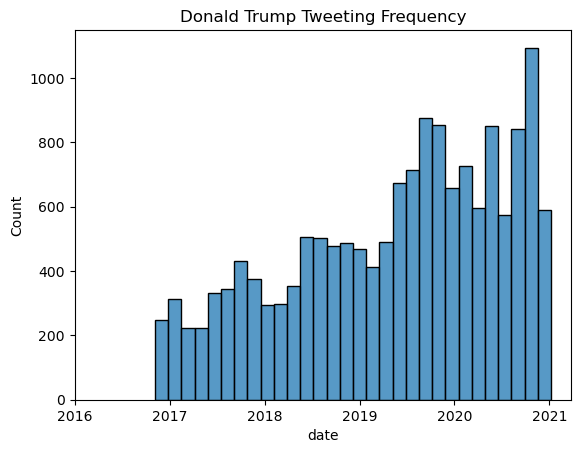

In [162]:
sns.histplot(df,
             x='date',
             #y='primary',
             cbar=True
             )

plt.xticks(ticks=[date.fromisoformat('2016-01-01'), date.fromisoformat('2017-01-01'),
                   date.fromisoformat('2018-01-01'), date.fromisoformat('2019-01-01'),
                   date.fromisoformat('2020-01-01'), date.fromisoformat('2021-01-01')],
                   labels=['2016','2017','2018','2019','2020','2021'])

plt.title('Donald Trump Tweeting Frequency')

plt.show()

Text(0.5, 1.0, 'Donald Trump RoBERTa Tweet Emotions Over Time - Deleted Tweets')

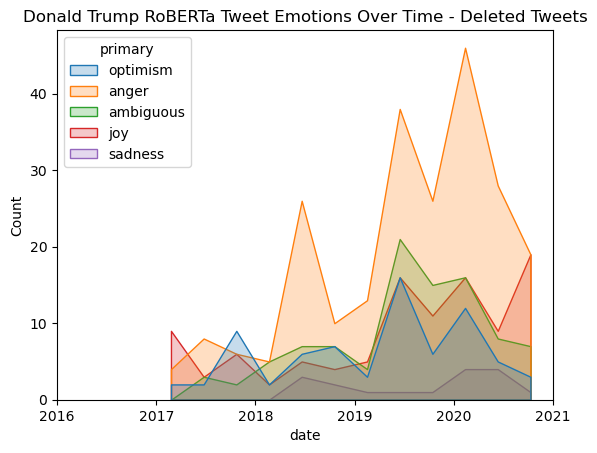

In [168]:
sns.histplot(
    df[df['isDeleted']=='t'], x="date", hue="primary", element="poly",
     common_norm=False,
)

plt.xticks(ticks=[date.fromisoformat('2016-01-01'), date.fromisoformat('2017-01-01'),
                   date.fromisoformat('2018-01-01'), date.fromisoformat('2019-01-01'),
                   date.fromisoformat('2020-01-01'), date.fromisoformat('2021-01-01')],
                   labels=['2016','2017','2018','2019','2020','2021'])

plt.title('Donald Trump RoBERTa Tweet Emotions Over Time - Deleted Tweets')

Text(0.5, 1.0, 'Distribution of Likelihood scores for RoBERTa Emotions')

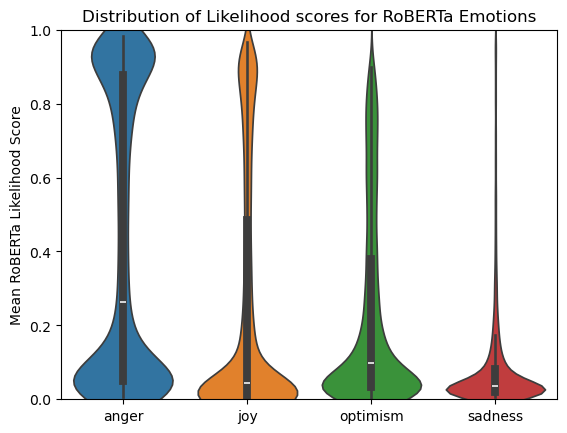

In [ ]:
sns.violinplot(data=df[['anger','joy','optimism','sadness']],
            #estimator='mean', 
            #errorbar=None,
            #legend=True,
            #capsize=0.2
            )


plt.ylim((0,1))
plt.ylabel('Mean RoBERTa Likelihood Score')
plt.title('Distribution of Likelihood scores for RoBERTa Emotions')


In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [209]:
vectorizer = TfidfVectorizer(stop_words=list(stopwords.words('english')) + ['http', 'https', 'amp', 'com', 'co'],
                             ngram_range=(1,2),
                             
                             )

In [229]:
df_roberta_tfidf = pd.DataFrame({'n_gram':[],
                                 'tf_idf':[],
                                 'primary':[]})

labels = ['anger', 'joy', 'optimism', 'sadness', 'ambiguous']

for label in labels:
    vectorizer.fit_transform(df[df['primary']==label]['text'])
    tfidf_matrix = vectorizer.fit_transform(df[df['primary']==label]['text'])
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()
    sorted_indices = np.argsort(tfidf_sums)[::-1]  # Descending order
    top_n = 5  # Number of words to extract
    top_words = feature_names[sorted_indices[:top_n]]
    top_scores = tfidf_sums[sorted_indices[:top_n]]

    # Print results
    print(label)
    for word, score in zip(top_words, top_scores):
        df_roberta_tfidf.loc[len(df_roberta_tfidf)] = [word, score, label]
        print(f"{word}: {score:.4f}")

anger
fake: 74.0087
news: 68.7034
democrats: 66.3682
people: 64.8361
fake news: 61.8308
joy
thank: 98.7568
great: 91.6773
big: 31.1350
congratulations: 30.6085
today: 28.3544
optimism
great: 59.5792
america: 47.2948
america great: 38.5304
make: 35.5247
make america: 32.8708
sadness
sad: 6.8125
people: 5.0971
great: 4.6931
prayers: 4.1535
families: 3.9863
ambiguous
great: 48.3147
trump: 30.0699
thank: 29.9056
president: 27.3570
big: 23.7223


Text(0.5, 1.0, 'RoBERTa Top 5 tf-idf Terms by Emotion')

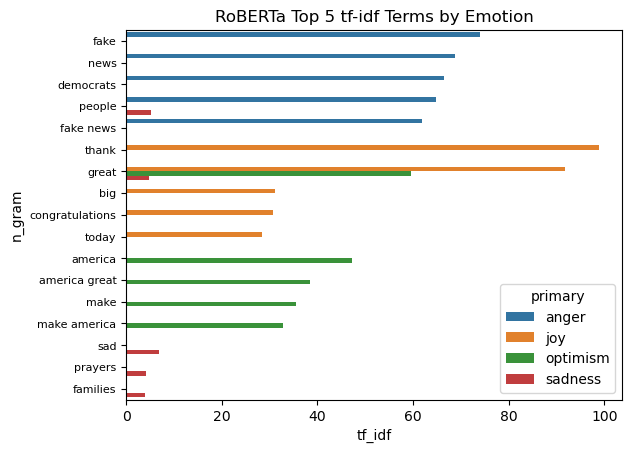

In [228]:
sns.barplot(
    df_roberta_tfidf,
    y='n_gram',
    x='tf_idf',
    hue='primary'
)

plt.yticks(ticks = df_roberta_tfidf['n_gram'].unique(),
           #rotation=90,
           fontsize=8);

plt.title('RoBERTa Top 5 tf-idf Terms by Emotion')